# 1. Background Information

# 2. Explanatory Data Analysis

In [1]:
# Import packages
import numpy as np
import pandas as pd
import os
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp
from IPython.core.interactiveshell import InteractiveShell

In [2]:
# Load data
sleep = pd.read_excel("2015SleepinAmericaPollSleepandPainRawDataExcel.xlsx")

## 2.1 Data Cleaning & Variable Construction

In [3]:
# Filter out observations without data for key variables of interets: time in bed and actual sleep data
sleep = sleep.loc[~(sleep.DOV_WEEKTIME.isna() | sleep.DOV_WEEKEND.isna() | sleep.DOV_TOTALWEEK.isna() | sleep.DOV_TOTALWEEKEND.isna())]

In [4]:
# Variable Construction

# average hours in bed per day
sleep['avg_bed'] = (sleep.DOV_WEEKTIME/ 60 * 5 + sleep.DOV_WEEKEND / 60 * 2)/ 7
# average actual sleep per day
sleep['avg_actual_sleep'] = (sleep.DOV_TOTALWEEK/ 60 * 5 + sleep.DOV_TOTALWEEKEND / 60 * 2)/ 7
 
# Define sleep efficiency as average actual sleep per day/average sleep hours per day
sleep['sleep_efficiency'] = sleep.avg_actual_sleep/sleep.avg_bed
sleep.loc[sleep.sleep_efficiency > 1, 'sleep_efficiency'] = 1

# Whether the person go to bed before or after mid-night on weekdays
sleep['before_mnt_week'] = 'Before Mid-night'
sleep.before_mnt_week.loc[sleep.Q2_ampmA == 1] = 'After Mid-night'
# Whether the person go to bed before or after mid-night on weekends
sleep['before_mnt_weekend'] = 'Before Mid-night'
sleep.before_mnt_weekend.loc[sleep.Q3_ampmA == 1] = 'After Mid-night'

# Sensitive to Environmental Factors
sleep['environ_sensitive'] = sleep.loc[:,['Q15_a', 'Q15_b','Q15_c', 'Q15_d', 'Q15_e']].mean(axis = 1)
sensitive_q3 = sleep.environ_sensitive.quantile(q = 0.75)
sleep['sensitive'] = 0
sleep.sensitive.loc[sleep.environ_sensitive > sensitive_q3] = 1

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
# Reverse Coding
def reverse_code(col):
    return col.max() - col + 1

# Environmental Factors
for i in ['a', 'b', 'c', 'd', 'e'] :
    sleep['Q15_' + str(i) + '_rev'] = reverse_code(sleep['Q15_' + str(i)])

# Motivation to make sure you have enough time to sleep
sleep['Q16_rev'] = reverse_code(sleep.Q16)

# Importance of going to bed at a suitable time
sleep['Q17_rev'] = reverse_code(sleep.Q17)

# Sleep Disorders
sleep['Q22_rev'] = sleep.Q22
sleep.loc[sleep.Q22 == 2, 'Q22_rev'] = 0

## 2.2 Individual Variables 

### 2.2.1 Sleep Quality

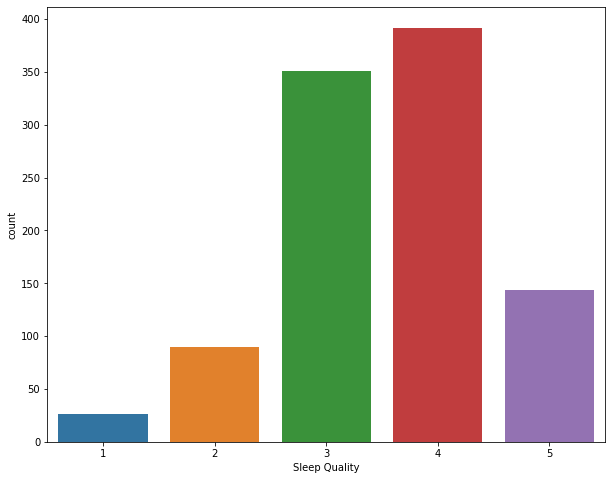

In [6]:
fig = plt.figure(figsize = [10,8])
sns.countplot(x="Q10_a", data=sleep)
plt.xlabel('Sleep Quality');

### 2.2.2 Average Hours in Bed Per Day

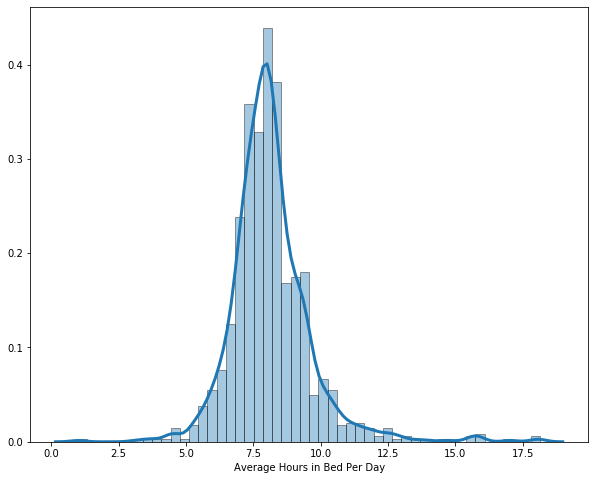

In [7]:
fig = plt.figure(figsize = [10,8])
sns.distplot(sleep.avg_bed, 
             hist = True, kde = True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

plt.xlabel('Average Hours in Bed Per Day');

- Outliers

(12, 206)
(130, 206)


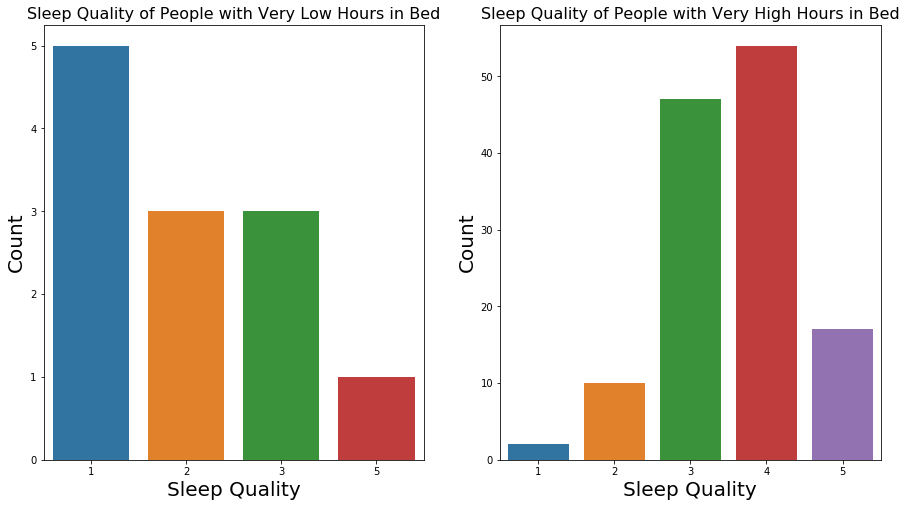

In [8]:
plt.figure(figsize = [15,8])

# Extract lower outliers for hours in bed
bed_Q1 = sleep['avg_bed'].quantile(0.25)
bed_Q3 = sleep['avg_bed'].quantile(0.75)
IQR = bed_Q3 - bed_Q1
bed_outlier_lower = sleep[(sleep.avg_bed <= bed_Q1 - 1.5 * IQR)]
print(bed_outlier_lower.shape)
bed_outlier_upper = sleep[(sleep.avg_bed >= bed_Q1 + 1.5 * IQR)]
print(bed_outlier_upper.shape)

# Sleep quality of people with very low hours in bed
plt.subplot(1,2,1)
sns.countplot(x="Q10_a", data=bed_outlier_lower)
plt.xlabel('Sleep Quality', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Sleep Quality of People with Very Low Hours in Bed', fontsize = 16)

# Sleep quality of people with very low hours in bed
plt.subplot(1,2,2)
sns.countplot(x="Q10_a", data=bed_outlier_upper)
plt.xlabel('Sleep Quality', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Sleep Quality of People with Very High Hours in Bed', fontsize = 16);

### 2.2.3 Average Actual Sleep Per Day

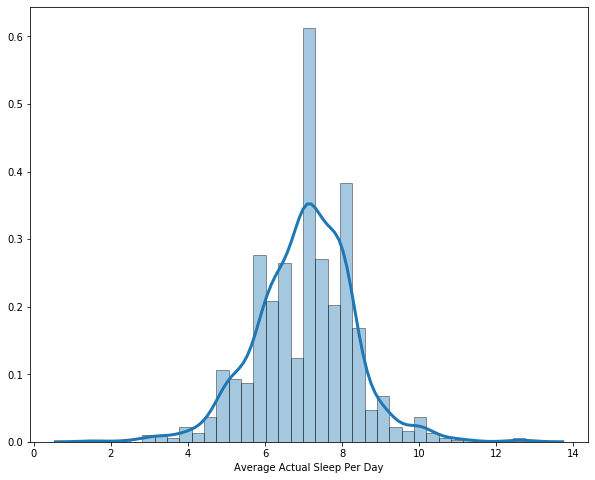

In [9]:
fig = plt.figure(figsize = [10,8])
sns.distplot(sleep.avg_actual_sleep, 
             hist = True, kde = True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

plt.xlabel('Average Actual Sleep Per Day');

- Outliers

(36, 206)
(23, 206)


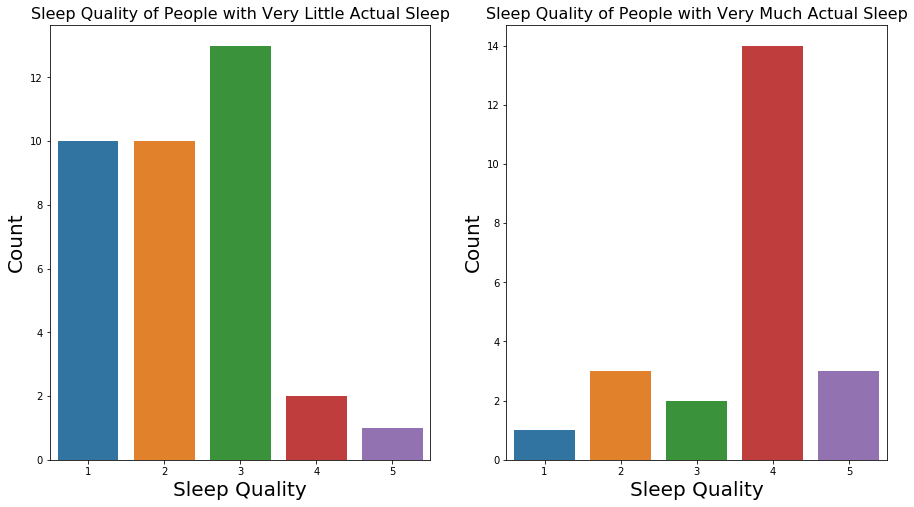

In [10]:
plt.figure(figsize = [15,8])

# Extract lower outliers for hours in bed
actual_sleep_Q1 = sleep['avg_actual_sleep'].quantile(0.25)
actual_sleep_Q3 = sleep['avg_actual_sleep'].quantile(0.75)
IQR = actual_sleep_Q3 - actual_sleep_Q1
actual_sleep_outlier_lower = sleep[(sleep.avg_actual_sleep <= bed_Q1 - 1.5 * IQR)]
print(actual_sleep_outlier_lower.shape)
actual_sleep_outlier_upper = sleep[(sleep.avg_actual_sleep >= bed_Q1 + 1.5 * IQR)]
print(actual_sleep_outlier_upper.shape)

# Sleep quality of people with very little actual sleep
plt.subplot(1,2,1)
sns.countplot(x="Q10_a", data = actual_sleep_outlier_lower)
plt.xlabel('Sleep Quality', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Sleep Quality of People with Very Little Actual Sleep', fontsize = 16)

# Sleep quality of people with very much actual sleep
plt.subplot(1,2,2)
sns.countplot(x="Q10_a", data=actual_sleep_outlier_upper)
plt.xlabel('Sleep Quality', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Sleep Quality of People with Very Much Actual Sleep', fontsize = 16);

### 2.2.4 Sleep Efficiency

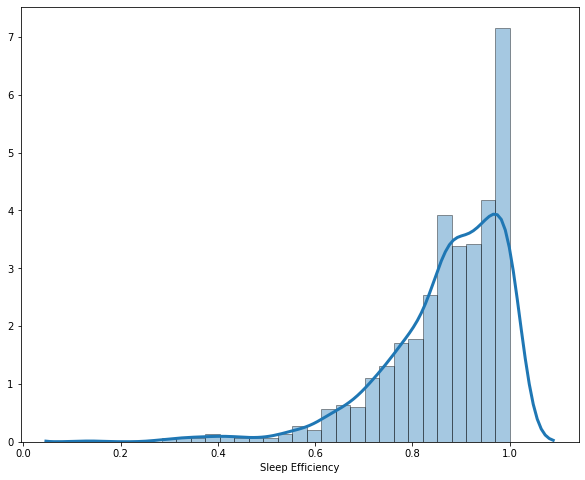

In [11]:
fig = plt.figure(figsize = [10,8])
sns.distplot(sleep.sleep_efficiency, 
             hist = True, kde = True,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

plt.xlabel('Sleep Efficiency');

- Outliers

(32, 206)


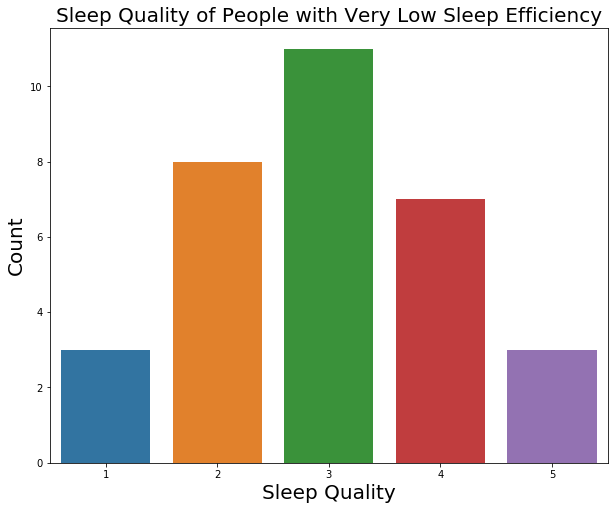

In [12]:
plt.figure(figsize = [10,8])

# Extract lower outliers for sleep efficiency 
eff_Q1 = sleep['sleep_efficiency'].quantile(0.25)
eff_Q3 = sleep['sleep_efficiency'].quantile(0.75)
IQR = eff_Q3 - eff_Q1
eff_outlier_lower = sleep[(sleep.sleep_efficiency <= eff_Q1 - 1.5 * IQR)]
print(eff_outlier_lower.shape)

# Sleep quality of people with very low sleep efficiency
sns.countplot(x="Q10_a", data=eff_outlier_lower)
plt.xlabel('Sleep Quality', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.title('Sleep Quality of People with Very Low Sleep Efficiency', fontsize = 20);

## 2.3 Relationship between Variables

### 2.3.1 Sleep Efficiency & Sleep Quality

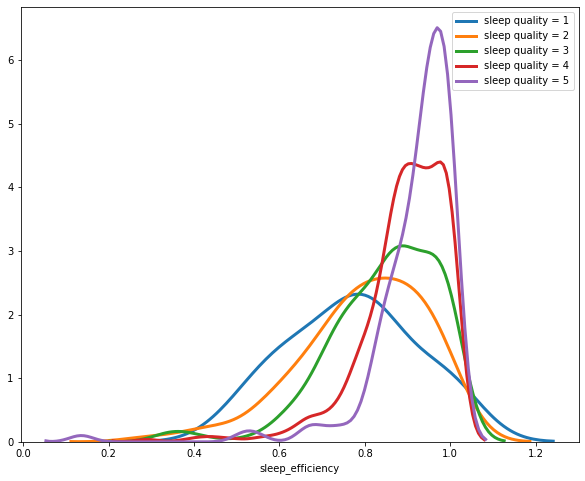

In [13]:
fig = plt.figure(figsize = [10,8])

for i in range(1,6): 
    sns.distplot(sleep.sleep_efficiency.loc[sleep.Q10_a == i], label = 'sleep quality = ' + str(i), hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.legend();

### 2.3.2 Average Hours in Bed & Sleep Quality

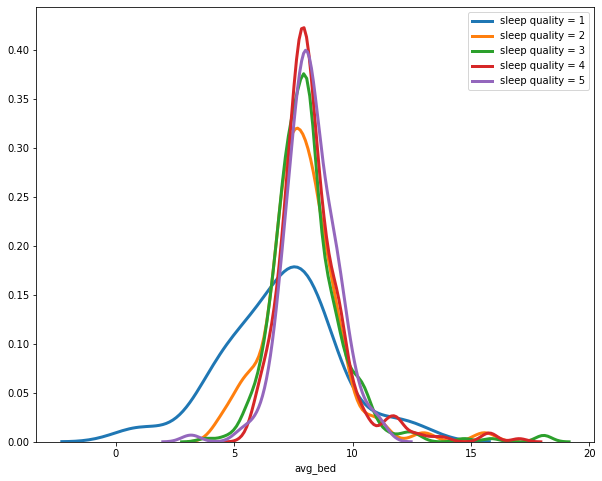

In [14]:
fig = plt.figure(figsize = [10,8])

for i in range(1,6): 
    sns.distplot(sleep.avg_bed.loc[sleep.Q10_a == i], label = 'sleep quality = ' + str(i), hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.legend();

### 2.3.2 Average Acutal Sleep & Sleep Quality

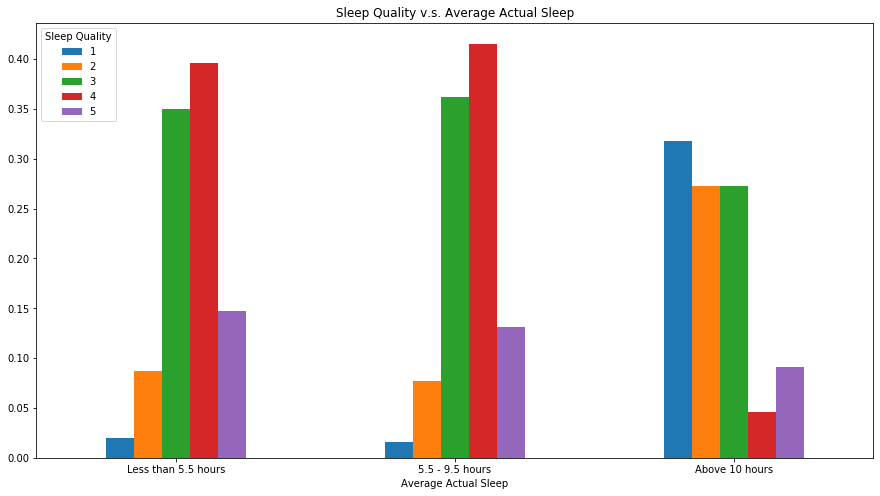

In [15]:
sleep['avg_bed_cat']=sleep['avg_bed']
#sleep['avg_bed2'].head(8)
sleep['avg_bed_cat'].loc[sleep.avg_bed <= 5.5] = "Less than 5.5 hours"
sleep['avg_bed_cat'].loc[(sleep.avg_bed > 5.5) & (sleep.avg_bed < 9.5)]= "5.5 - 9.5 hours"
sleep['avg_bed_cat'].loc[sleep.avg_bed >= 9.5] = "Above 10 hours"

bar_data_avg_bed = sleep.groupby('avg_bed_cat').Q10_a.value_counts(normalize=True).unstack()
bar_data_avg_bed.plot(rot=0, kind = 'bar',title = 'Sleep Quality v.s. Average Actual Sleep', figsize=(15,8))
plt.legend(loc = 'upper left', title = 'Sleep Quality')
plt.xticks([0,1,2], ["Less than 5.5 hours", "5.5 - 9.5 hours", "Above 10 hours"])
plt.xlabel('Average Actual Sleep');

### 2.3.2 Time Go to Bed & Sleep Efficiency

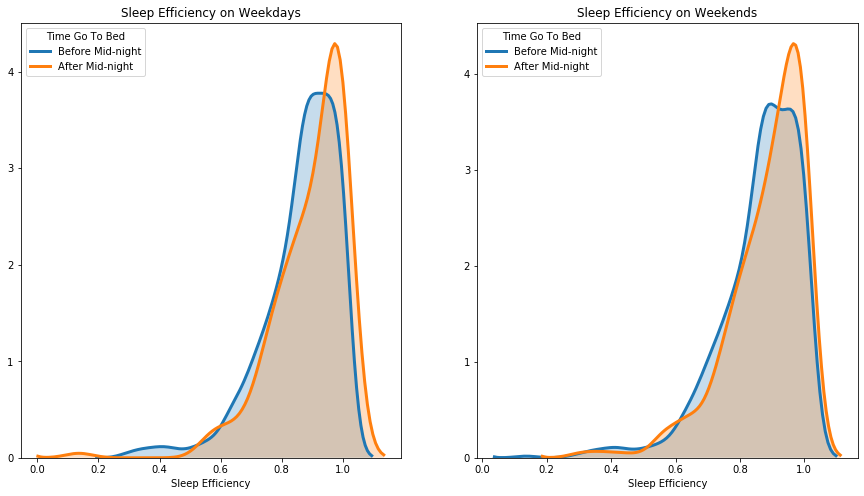

In [16]:
fig = plt.figure(figsize = [15,8])

# Weekdays
ax = fig.add_subplot(121)
sns.distplot(sleep.sleep_efficiency.loc[sleep.before_mnt_week == 'Before Mid-night'], label = 'Before Mid-night', hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3, "shade": True},
            ax = ax)

sns.distplot(sleep.sleep_efficiency.loc[sleep.before_mnt_week == 'After Mid-night'], label = 'After Mid-night', hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3, "shade": True},
            ax = ax)

plt.title('Sleep Efficiency on Weekdays')
plt.legend(loc = 'upper left', title = 'Time Go To Bed')
plt.xlabel('Sleep Efficiency')

# Weekends
ax = fig.add_subplot(122)
sns.distplot(sleep.sleep_efficiency.loc[sleep.before_mnt_weekend == 'Before Mid-night'], label = 'Before Mid-night', hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3, "shade": True},
            ax = ax)

sns.distplot(sleep.sleep_efficiency.loc[sleep.before_mnt_weekend == 'After Mid-night'], label = 'After Mid-night', hist = False, kde=True, 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3, "shade": True},
            ax = ax)
plt.title('Sleep Efficiency on Weekends')
plt.legend(loc = 'upper left',title = 'Time Go To Bed')
plt.xlabel('Sleep Efficiency');

### 2.3.3 Time Go to Bed & Sleep Quality

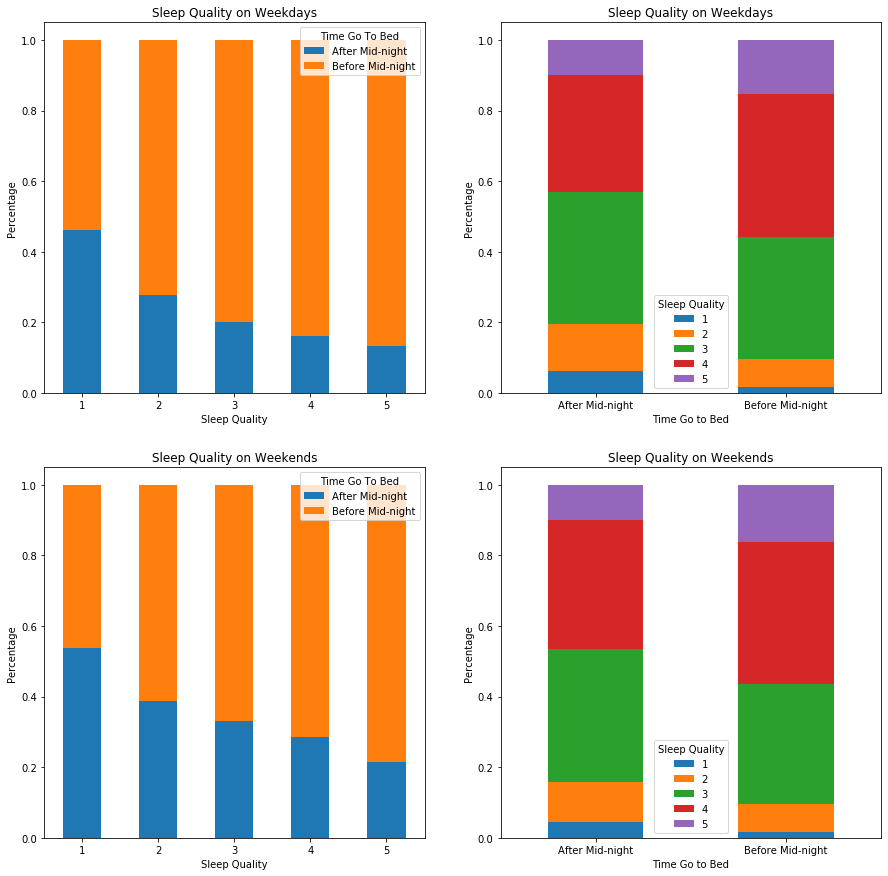

In [17]:
fig = plt.figure(figsize = [15,15])

# Weekdays
ax = fig.add_subplot(221)
bar_data_week = sleep.groupby('Q10_a').before_mnt_week.value_counts(normalize=True).unstack()
bar_data_week.plot(rot=0, kind = 'bar',title = 'Sleep Quality on Weekdays', stacked = True, ax = ax)
plt.legend(title = 'Time Go To Bed')
plt.xlabel('Sleep Quality')
plt.ylabel('Percentage')

# Weekends
ax = fig.add_subplot(223)
bar_data_weekend = sleep.groupby('Q10_a').before_mnt_weekend.value_counts(normalize=True).unstack()
bar_data_weekend.plot(rot=0, kind = 'bar',title = 'Sleep Quality on Weekends', stacked = True, ax = ax)
plt.legend(title = 'Time Go To Bed')
plt.xlabel('Sleep Quality')
plt.ylabel('Percentage')

# Weekdays
ax = fig.add_subplot(222)
bar_data_week2 = sleep.groupby('before_mnt_week').Q10_a.value_counts(normalize=True).unstack()
bar_data_week2.plot(rot=0, kind = 'bar', title = 'Sleep Quality on Weekdays', stacked = True, ax = ax)
plt.legend(title = 'Sleep Quality')
plt.xlabel('Time Go to Bed')
plt.ylabel('Percentage')


# Weekends
ax = fig.add_subplot(224)
bar_data_weekend2 = sleep.groupby('before_mnt_weekend').Q10_a.value_counts(normalize=True).unstack()

bar_data_weekend2.plot(rot=0, kind = 'bar',title = 'Sleep Quality on Weekends', stacked = True, ax = ax)
plt.legend(title = 'Sleep Quality')
plt.xlabel('Time Go to Bed')
plt.ylabel('Percentage')

plt.show();

### 2.3.4 Sleep Disorders & Sleep Quality

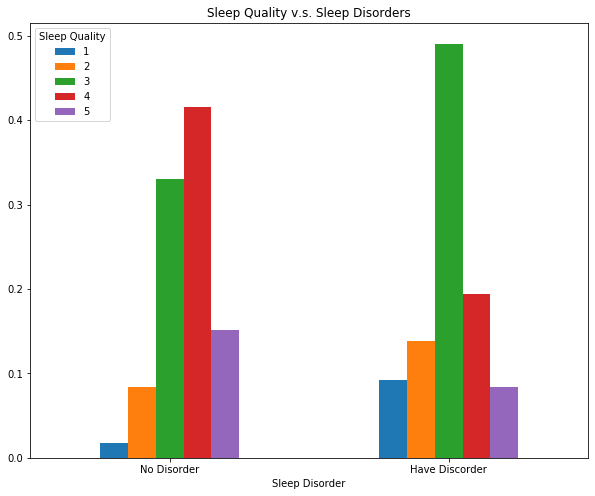

In [18]:
bar_data_disorder = sleep.loc[sleep.Q22_rev != -1].groupby('Q22_rev').Q10_a.value_counts(normalize=True).unstack()
bar_data_disorder.plot(rot=0, kind = 'bar',title = 'Sleep Quality v.s. Sleep Disorders', figsize=(10,8))
plt.legend(loc = 'upper left', title = 'Sleep Quality')
plt.xticks([0,1], ['No Disorder', 'Have Discorder'])
plt.xlabel('Sleep Disorder');

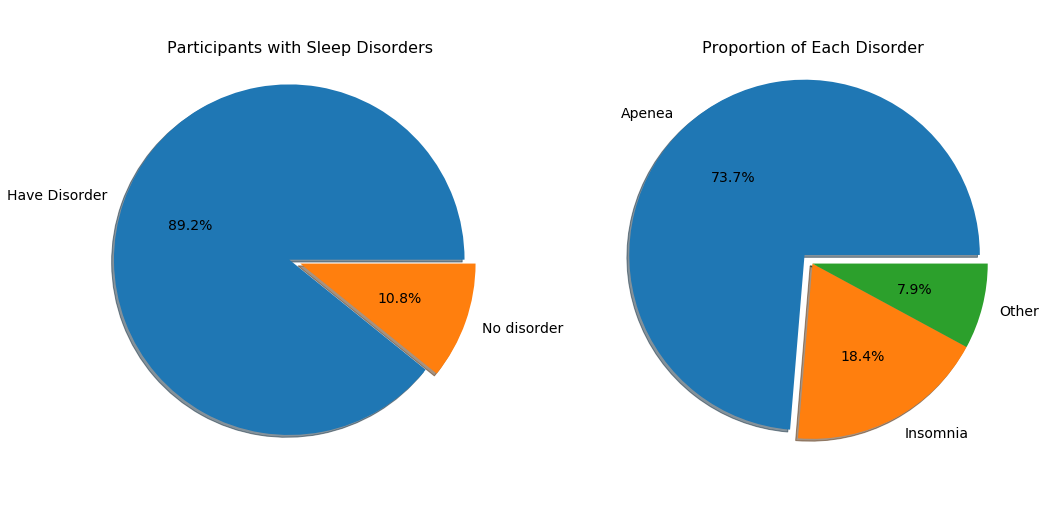

In [19]:
fig = plt.figure(figsize = [15,8])
plt.subplot(1,2,1)

labels = 'Have Disorder','No disorder'
sizes = [sleep.Q22_rev.value_counts()[0], sleep.Q22_rev.value_counts()[1]]
plt.axis('equal')
plt.pie(sizes, labels=labels,radius=1.5,autopct='%0.1f%%',shadow=True,explode=[0.1,0],textprops={'fontsize': 14})
plt.title('Participants with Sleep Disorders', y = 0.9, size = 16)

labels = 'Apenea', 'Insomnia', 'Other'
sizes = [sleep['Q23_a'].value_counts()[1], sleep['Q23_b'].value_counts()[1],sleep['Q23_c'].value_counts()[1]]
plt.subplot(1,2,2)
plt.axis('equal')
plt.pie(sizes, labels=labels, radius=1.5,autopct='%0.1f%%',shadow=True,explode=[0.1,0,0], textprops = {'fontsize': 14})
plt.title('Proportion of Each Disorder', y = 0.9, size = 16)
plt.tight_layout(w_pad = 4);

### 2.3.5 Other Factors Correlated with Sleep Quality

<Figure size 1080x1080 with 0 Axes>

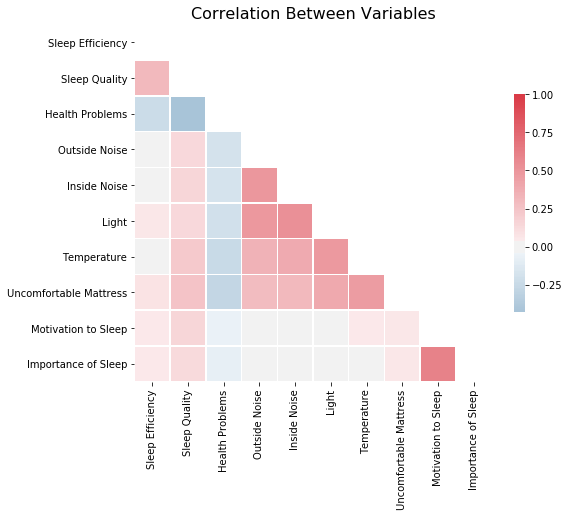

In [20]:
corr_data = sleep.loc[:, ['sleep_efficiency', 'Q10_a','Q14a','Q15_a_rev', 'Q15_b_rev', 'Q15_c_rev', 'Q15_d_rev', 'Q15_e_rev','Q16_rev', 'Q17_rev']]
corr_data = corr_data.loc[(sleep.Q15_a_rev != 7) & (sleep.Q15_b_rev != 7) & (sleep.Q15_c_rev != 7) & (sleep.Q15_d_rev != 7) & (sleep.Q15_e_rev != 7) & (sleep.Q16_rev != 7) & (sleep.Q17_rev != 7) ]
corr_data.columns = ['Sleep Efficiency', 'Sleep Quality', 'Health Problems', 'Outside Noise', 'Inside Noise', 'Light','Temperature', 'Uncomfortable Mattress', 'Motivation to Sleep', 'Importance of Sleep']

fig = plt.figure(figsize = [15,15])
corr = corr_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
figure, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(600, 10, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, center=0,
            square = True, linewidths = .5, cbar_kws={"shrink": .5})
plt.title('Correlation Between Variables', size = 16);

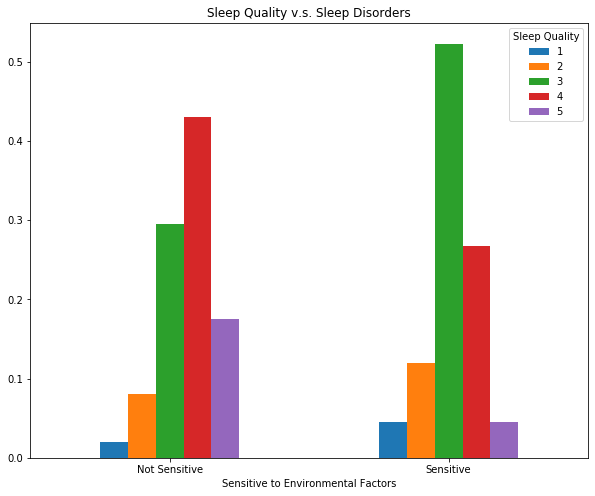

In [21]:
bar_data_sensitive = sleep.groupby('sensitive').Q10_a.value_counts(normalize=True).unstack()

bar_data_sensitive.plot(rot=0,kind = 'bar', figsize=(10,8))
plt.title('Sleep Quality v.s. Sleep Disorders')
plt.legend(title = 'Sleep Quality')
plt.xticks([0,1], ['Not Sensitive', 'Sensitive'])
plt.xlabel('Sensitive to Environmental Factors');

In [22]:
# Number of people with sleeping efficiency < 0.8
sleep.loc[sleep.sleep_efficiency < 0.8].shape

(232, 207)

##  Regression for Sleep Quality and Bedtime